# Time Series Forecasting Playbook — Theory

*A crisp, practical overview of how to think about forecasting time series with classical statistics, machine learning, and deep learning.*

This notebook walks through:
- Problem framing and common setups
- Data preparation and leakage pitfalls
- Baselines you must always include
- Classical models (ARIMA/SARIMA, ETS, state-space)
- Machine learning (feature-based global models)
- Deep learning (RNN/CNN/Transformers)
- Evaluation, backtesting, and uncertainty
- Visualization patterns and experiment design checklist


## Dataset: Kaggle — Hourly Energy Consumption (PJME)

**Source.** Kaggle dataset by robikscube: “Hourly Energy Consumption.” We will use the `PJME_hourly.csv` file (PJM East region).

**Why this dataset works across all models**
- **Frequency:** Hourly (`H`) → rich short-term dynamics.
- **Seasonality:** Strong **daily (24h)** and **weekly (168h)** cycles.
- **Trend + noise:** Realistic medium-term trend with stochastic fluctuations.
- **Length:** Multiple years → enough samples for ML/DL windowing.

**Target variable**
- `y`: electricity demand in megawatts (MW), derived from the `*_MW` column.

**Experiment defaults**
- Forecast horizon: `H = 24 * 7` (one week ahead).
- Seasonality hints: `SEASON_DAILY = 24`, `SEASON_WEEKLY = 168`.

> We will reuse this same dataset for baselines, SARIMA, XGBoost, and LSTM to ensure apples-to-apples comparisons.



Duplicate timestamps: 4 unique timestamps duplicated, 4 extra rows.
Shape: (145392, 1)
Range: 2002-01-01 01:00:00 → 2018-08-03 00:00:00
                           y
Datetime                    
2002-01-01 01:00:00  30393.0
2002-01-01 02:00:00  29265.0
2002-01-01 03:00:00  28357.0
2002-01-01 04:00:00  27899.0
2002-01-01 05:00:00  28057.0
                   y
count  145392.000000
mean    32078.927654
std      6464.283311
min     14544.000000
25%     27571.000000
50%     31420.000000
75%     35647.000000
max     62009.000000


/var/folders/8y/f4ylyqm91cg9b6hsg42qpkk00000gn/T/ipykernel_6345/1134722475.py:50: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df = df.asfreq(FREQ)


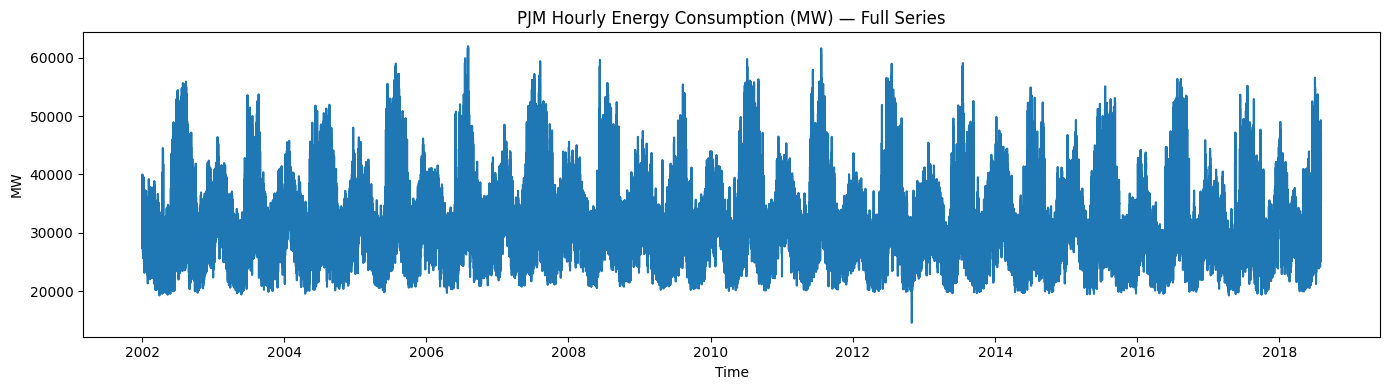

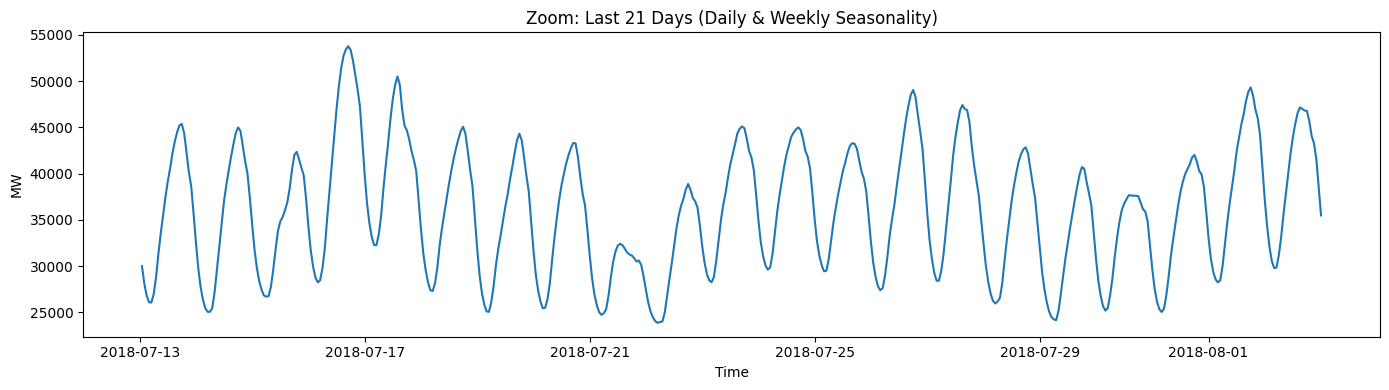

Train size: 145224 points, Test size: 168 points


In [4]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# ---------------- Configuration ----------------
DATA_DIR = "./"            # change if needed
FILENAME = "PJME_hourly.csv"

FREQ = 'H'
H = 24 * 7
SEASON_DAILY = 24
SEASON_WEEKLY = 168

# ---------------- Load ----------------
path = os.path.join(DATA_DIR, FILENAME)
if not os.path.exists(path):
    raise FileNotFoundError(f"CSV not found at {path}")

raw = pd.read_csv(path, parse_dates=['Datetime'])
if 'Datetime' not in raw.columns:
    raise ValueError("Expected a 'Datetime' column in the CSV.")

# Identify the MW column (e.g., 'PJME_MW')
mw_cols = [c for c in raw.columns if c.endswith('_MW')]
if len(mw_cols) != 1:
    raise ValueError(f"Expected exactly one '*_MW' column, found: {mw_cols}")
target_col = mw_cols[0]

# Keep only timestamp + target, rename to y
df = raw[['Datetime', target_col]].rename(columns={target_col: 'y'}).copy()

# ---- Handle duplicate timestamps (DST fall-back, data quirks) ----
# Count duplicates
dup_counts = df['Datetime'].value_counts()
num_dups = int((dup_counts > 1).sum())
total_dup_rows = int((dup_counts[dup_counts > 1] - 1).sum())
print(f"Duplicate timestamps: {num_dups} unique timestamps duplicated, {total_dup_rows} extra rows.")

# Aggregate duplicates by mean (you can switch to .last()/.first() if desired)
df = (
    df.groupby('Datetime', as_index=False, sort=True)
      .agg({'y': 'mean'})
      .set_index('Datetime')
      .sort_index()
)

# ---- Align to regular hourly grid and interpolate small gaps ----
# (after de-duplication, asfreq works safely)
df = df.asfreq(FREQ)

# Interpolate short gaps only to avoid creating artificial data
df['y'] = df['y'].interpolate(method='time', limit=6, limit_direction='both')

# Basic overview
print("Shape:", df.shape)
print("Range:", df.index.min(), "→", df.index.max())
print(df.head())
print(df.describe())

# ---------------- Plots ----------------
plt.figure(figsize=(14, 4))
plt.plot(df.index, df['y'])
plt.title('PJM Hourly Energy Consumption (MW) — Full Series')
plt.xlabel('Time'); plt.ylabel('MW'); plt.tight_layout(); plt.show()

# Zoom in to reveal daily/weekly seasonality (last 21 days)
last_n = SEASON_DAILY * 21
zoom = df.iloc[-last_n:]
plt.figure(figsize=(14, 4))
plt.plot(zoom.index, zoom['y'])
plt.title('Zoom: Last 21 Days (Daily & Weekly Seasonality)')
plt.xlabel('Time'); plt.ylabel('MW'); plt.tight_layout(); plt.show()

# Keep a standardized split for all experiments
train = df.iloc[:-H].copy()
test = df.iloc[-H:].copy()
print(f"Train size: {train.shape[0]} points, Test size: {test.shape[0]} points")

# Helpers for later plots
def plot_full_and_zoom(train, test, yhat=None, title='Forecast'):
    plt.figure(figsize=(14, 4))
    plt.plot(train.index, train['y'], label='Train')
    plt.plot(test.index, test['y'], label='Test', color='black')
    if yhat is not None:
        plt.plot(test.index, yhat, label='Forecast')
    plt.legend(); plt.title(f'{title} — Full'); plt.tight_layout(); plt.show()

    pad = SEASON_WEEKLY  # one week of context before test
    zoom_start = max(train.index[0], test.index[0] - pd.Timedelta(hours=pad))
    hist_zoom = train.loc[zoom_start:]
    plt.figure(figsize=(14, 4))
    plt.plot(hist_zoom.index, hist_zoom['y'], label='Train')
    plt.plot(test.index, test['y'], label='Test', color='black')
    if yhat is not None:
        plt.plot(test.index, yhat, label='Forecast')
    plt.legend(); plt.title(f'{title} — Zoom'); plt.tight_layout(); plt.show()



## 1) Problem Framing

**Goal.** Given a (uni/multi)variate time series $y_t$ with optional exogenous variables $x_t$, learn a function $f$ to predict future values $\hat{y}_{t+h} = f(\mathcal{H}_t, x_{t:t+h})$ for horizons $h \in \{1, \dots, H\}$.

**Common setups**
- **One-step** vs **multi-step** (recursive, direct, multi-output).
- **Univariate** vs **multivariate** vs **global** (trained across many series).
- **Point** forecasts vs **probabilistic** (quantiles or full distributions).

**Key assumptions & pitfalls**
- Temporal dependence (no IID): use chronological CV/backtesting, not random K-folds.
- Non-stationarity (trend, seasonality, regime shifts): transform or use models that handle it.
- Data leakage: do not use future info when creating features, scalers, or imputations.


## 2) Baselines

Always start with simple models:

- **Naive:** $\hat{y}_{t+1} = y_t$
- **Seasonal naive:** $\hat{y}_{t+h} = y_{t+h-s}$ with period $s$
- **Mean/Drift:** average or linear drift extrapolation.

> If a complex model does not outperform baselines, fix data or evaluation before adding complexity.


                             MAE      RMSE
Naive                   5712.095  6719.734
Seasonal Naive (s=24)   3578.149  4443.838
Seasonal Naive (s=168)  3335.518  4109.705


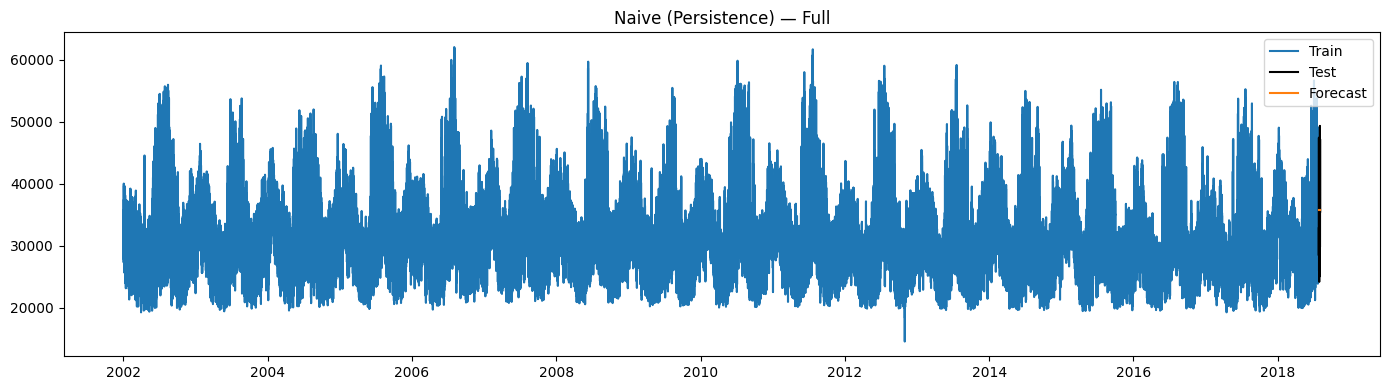

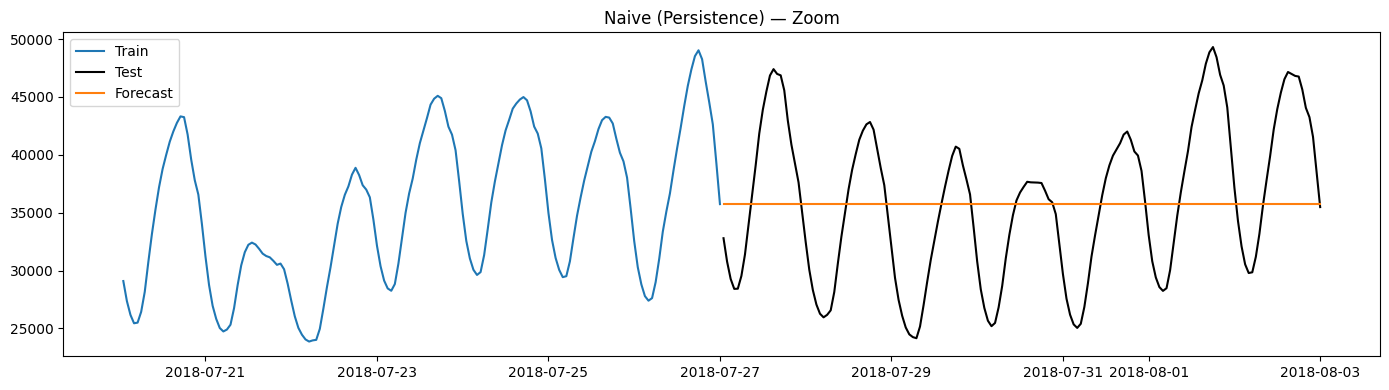

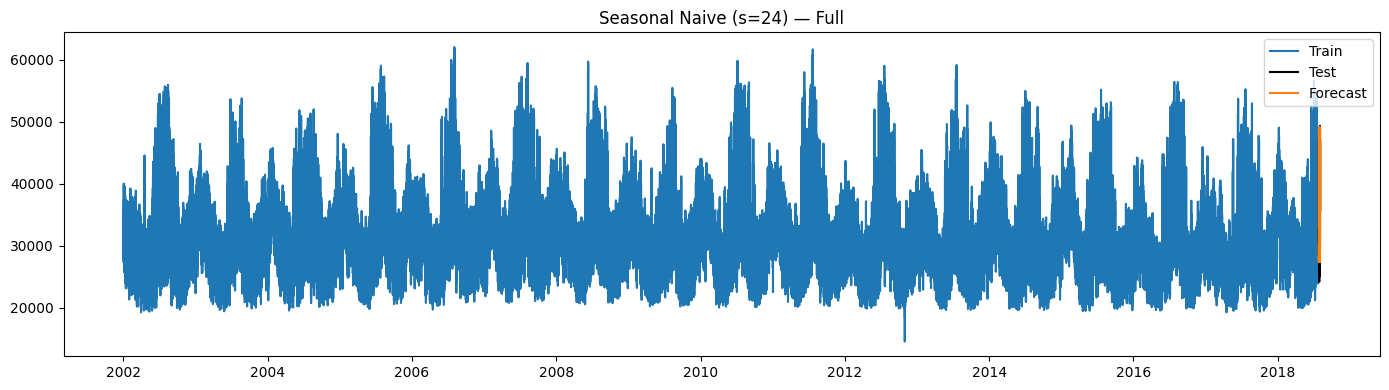

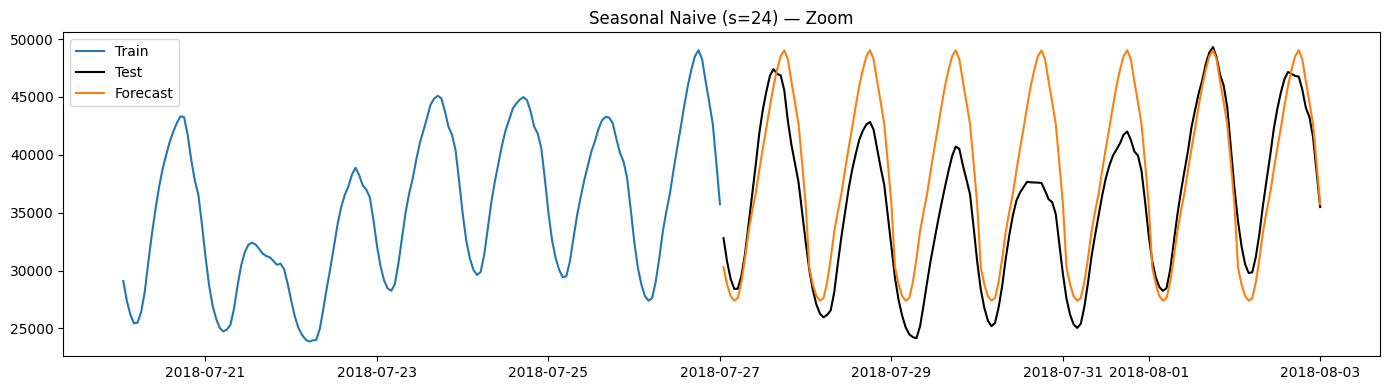

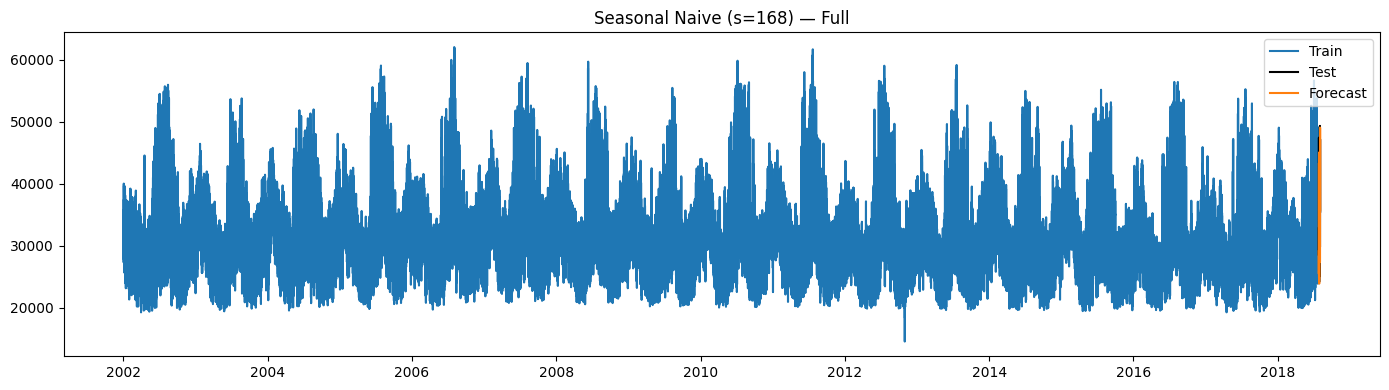

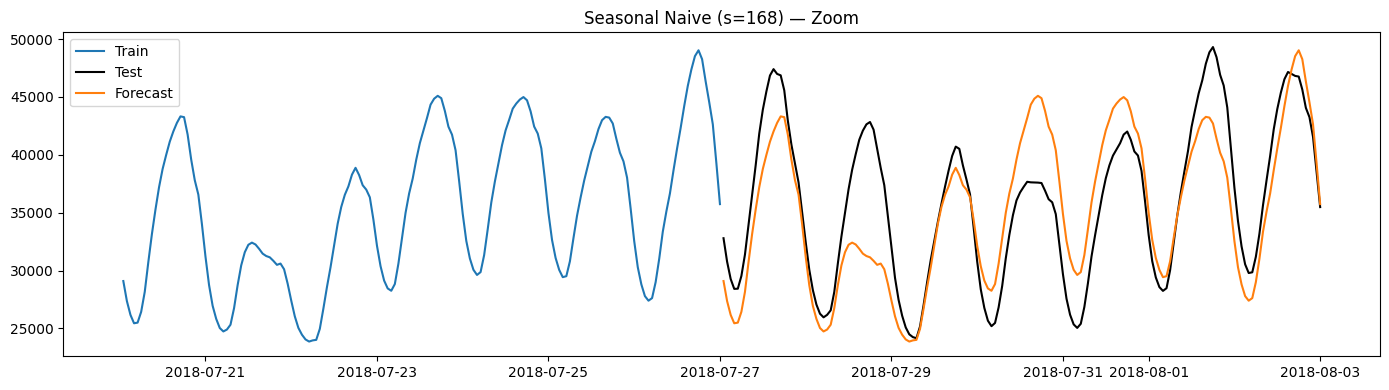

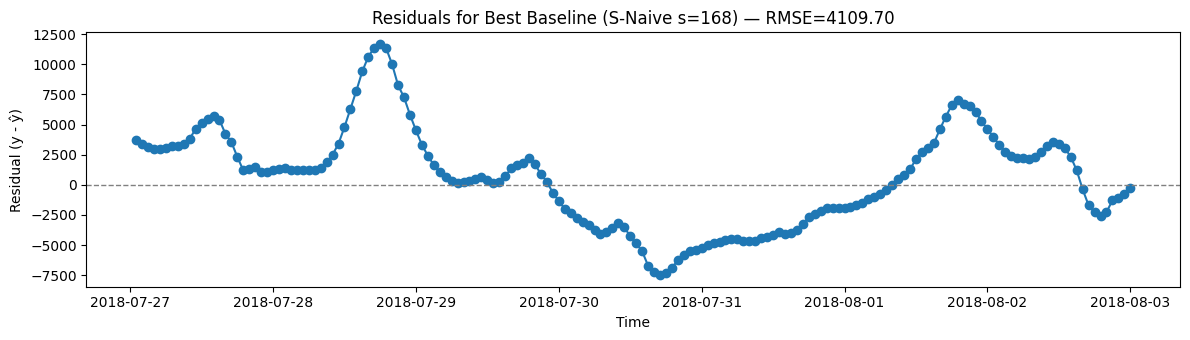

In [13]:
# ==== Baseline Experiments: Naive & Seasonal Naive ====
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn.metrics as skm

# Expect train/test, SEASON_DAILY/SEASON_WEEKLY, H, and plot_full_and_zoom to be defined.

def naive_persistence(series: pd.Series, horizon: int) -> np.ndarray:
    last = float(series.iloc[-1])
    return np.full(horizon, last, dtype=float)

def seasonal_naive(series: pd.Series, horizon: int, season: int = 24) -> np.ndarray:
    if len(series) < season:
        raise ValueError(f"Series length ({len(series)}) must be >= season ({season})")
    last_cycle = series.iloc[-season:].to_numpy()
    reps = int(np.ceil(horizon / season))
    return np.tile(last_cycle, reps)[:horizon].astype(float)

# Compute forecasts
y_true = test['y'].to_numpy()
pred_naive = naive_persistence(train['y'], H)
pred_snaive_24 = seasonal_naive(train['y'], H, season=SEASON_DAILY)
pred_snaive_168 = seasonal_naive(train['y'], H, season=SEASON_WEEKLY)

def metrics(y, yhat):
    mae = skm.mean_absolute_error(y, yhat)
    mse = skm.mean_squared_error(y, yhat)
    rmse = np.sqrt(mse)
    return mae, rmse

mae_n, rmse_n = metrics(y_true, pred_naive)
mae_s24, rmse_s24 = metrics(y_true, pred_snaive_24)
mae_s168, rmse_s168 = metrics(y_true, pred_snaive_168)

metrics_df = pd.DataFrame(
    {"MAE": [mae_n, mae_s24, mae_s168],
     "RMSE": [rmse_n, rmse_s24, rmse_s168]},
    index=["Naive", f"Seasonal Naive (s={SEASON_DAILY})", f"Seasonal Naive (s={SEASON_WEEKLY})"]
)
print(metrics_df.round(3))

# Plots
plot_full_and_zoom(train, test, pred_naive, title='Naive (Persistence)')
plot_full_and_zoom(train, test, pred_snaive_24, title=f'Seasonal Naive (s={SEASON_DAILY})')
plot_full_and_zoom(train, test, pred_snaive_168, title=f'Seasonal Naive (s={SEASON_WEEKLY})')

# Residuals for best baseline
best_label, best_pred, best_rmse = min(
    [("Naive", pred_naive, rmse_n),
     (f"S-Naive s={SEASON_DAILY}", pred_snaive_24, rmse_s24),
     (f"S-Naive s={SEASON_WEEKLY}", pred_snaive_168, rmse_s168)],
    key=lambda t: t[2]
)
residuals = y_true - best_pred
plt.figure(figsize=(12, 3.5))
plt.plot(test.index, residuals, marker='o')
plt.axhline(0, color='gray', linestyle='--', linewidth=1)
plt.title(f'Residuals for Best Baseline ({best_label}) — RMSE={best_rmse:.2f}')
plt.xlabel('Time'); plt.ylabel('Residual (y - ŷ)')
plt.tight_layout(); plt.show()



## Classical Statistical Approaches

These models view a time series as a stochastic process — a realization of an underlying probability distribution evolving through time.  
They focus on capturing **trend**, **seasonality**, and **autocorrelation** directly in the temporal domain, often assuming some degree of **stationarity** (stable mean and variance after transformation).

**Core ideas**
- The observed series $y_t$ can be decomposed into components:
  $$
  y_t = T_t + S_t + R_t,
  $$
  where $T_t$ is trend, $S_t$ is seasonal pattern, and $R_t$ is residual (noise).
- Dependencies are modeled explicitly: past values and past errors inform future predictions.
- Parameters are estimated statistically (maximum likelihood), producing interpretable coefficients and often analytic prediction intervals.

**Main families**
- **ARIMA/SARIMA** — autoregressive + differencing + moving average models (and their seasonal extensions).
- **ETS (Exponential Smoothing)** — weighted recency for level, trend, and seasonality.
- **STL decomposition + residual modeling** — separate structure, then model remainder.
- **State-space models (Kalman filter, Dynamic Linear Models)** — probabilistic framework for latent trend/seasonal states.

> Classical models excel on well-behaved univariate series with clear seasonality and relatively short horizons. They are interpretable and provide built-in uncertainty estimates, making them a solid baseline before moving to ML or DL.


### ARIMA / SARIMA

**ARIMA (AutoRegressive Integrated Moving Average)** combines three ideas:

1. **Autoregression (AR):** past values influence the current observation.
   $$
   y_t = c + \phi_1 y_{t-1} + \dots + \phi_p y_{t-p} + \varepsilon_t
   $$
2. **Integration (I):** differencing makes a non-stationary series stationary.
3. **Moving Average (MA):** current value depends on past forecast errors.
   $$
   y_t = c + \varepsilon_t + \theta_1 \varepsilon_{t-1} + \dots + \theta_q \varepsilon_{t-q}
   $$

**SARIMA** adds seasonal components $(P, D, Q, s)$ to capture repeating patterns (e.g., daily or weekly in hourly data).

These models yield interpretable coefficients, residual diagnostics, and analytical confidence intervals.  
They are best for univariate series with stable seasonal/trend structure.


SARIMA (order=(2, 1, 2), seasonal=(1, 1, 1, 24)) → MAE=4966.817, RMSE=5732.222


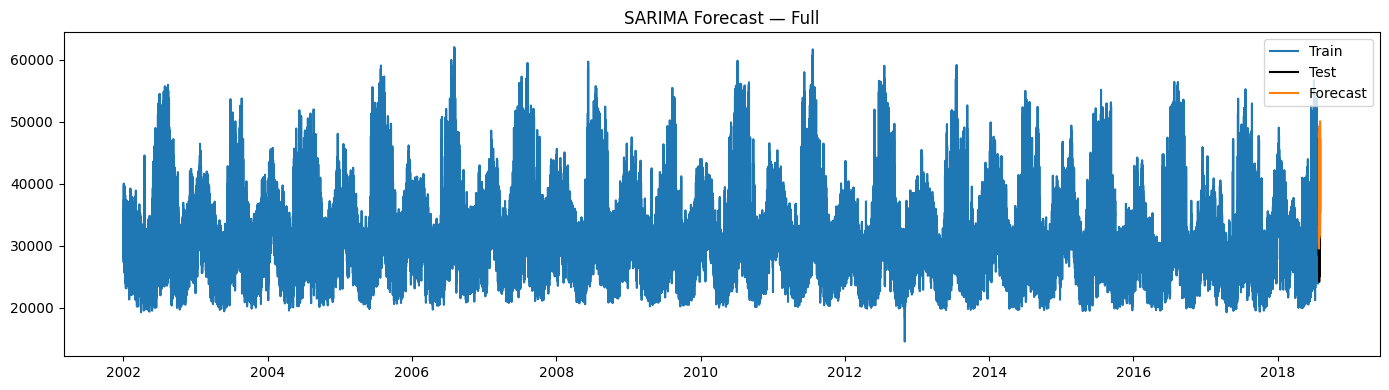

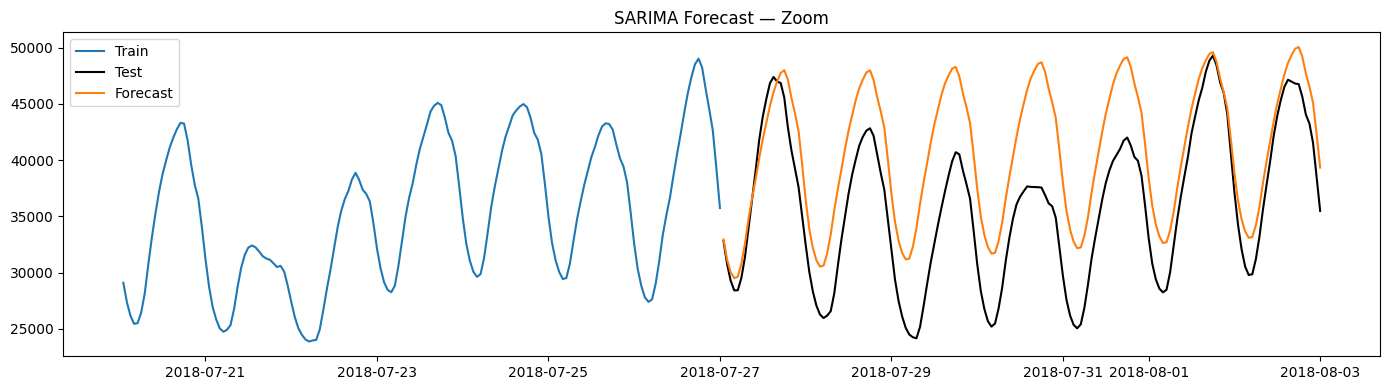

ValueError: x and y must have same first dimension, but have shapes (168,) and (145224,)

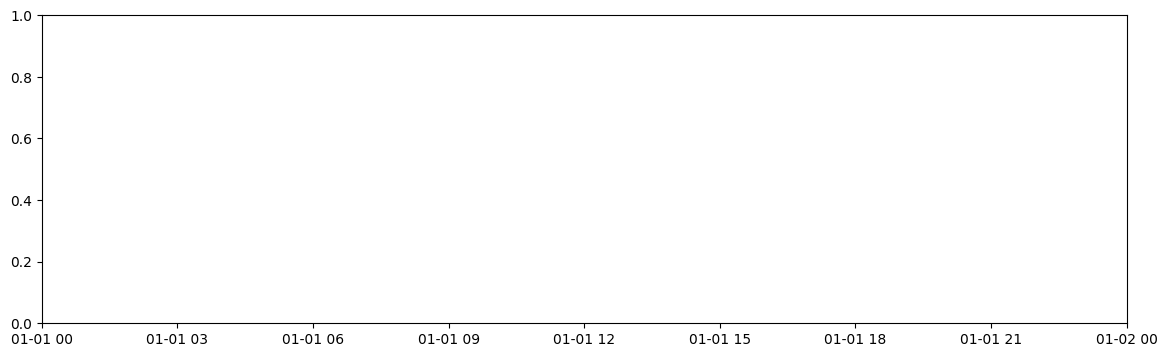

In [14]:
# ==== Classical Model: SARIMA (Seasonal ARIMA) ====
import warnings
import statsmodels.api as sm
from sklearn.metrics import mean_absolute_error, mean_squared_error

warnings.filterwarnings("ignore")

# Fit SARIMAX model: simple seasonal daily pattern (s=24)
"""order = (2, 1, 2)
seasonal_order = (1, 1, 1, SEASON_DAILY)

model = sm.tsa.statespace.SARIMAX(
    train['y'],
    order=order,
    seasonal_order=seasonal_order,
    enforce_stationarity=False,
    enforce_invertibility=False
)
res = model.fit(disp=False)
print(res.summary().tables[1])
"""
# Short version to run quickly
train_short = train.last("730D")
order = (2, 1, 2)
seasonal_order = (1, 1, 1, 24)

model = sm.tsa.statespace.SARIMAX(
    train_short['y'],
    order=order,
    seasonal_order=seasonal_order,
    enforce_stationarity=False,
    enforce_invertibility=False
)
res = model.fit(disp=False, method='powell', maxiter=50)

# Forecast horizon
forecast = res.get_forecast(steps=H)
pred_mean = forecast.predicted_mean
ci = forecast.conf_int(alpha=0.2)  # 80% interval

# Metrics
mae, rmse = metrics(test['y'], pred_mean)
print(f"SARIMA (order={order}, seasonal={seasonal_order}) → MAE={mae:.3f}, RMSE={rmse:.3f}")

# Plots
plot_full_and_zoom(train, test, pred_mean, title='SARIMA Forecast')

# Confidence interval zoom
plt.figure(figsize=(14,4))
plt.plot(train.index[-SEASON_WEEKLY:], train['y'], label='Train')
plt.plot(test.index, test['y'], label='Test', color='black')
plt.plot(test.index, pred_mean, label='Forecast', color='tab:blue')
plt.fill_between(test.index, ci.iloc[:,0], ci.iloc[:,1], alpha=0.3, color='lightblue', label='80% CI')
plt.legend(); plt.title('SARIMA Forecast with Confidence Interval — Zoom'); plt.tight_layout(); plt.show()

# Residual diagnostics
residuals = res.resid
fig, axes = plt.subplots(1, 2, figsize=(12, 3))
axes[0].plot(residuals[-SEASON_WEEKLY:])
axes[0].axhline(0, color='gray', lw=1)
axes[0].set_title('Residuals (Last Week)')
sm.graphics.tsa.plot_acf(residuals.dropna(), lags=48, ax=axes[1])
axes[1].set_title('Residual ACF')
plt.tight_layout(); plt.show()


### ETS (Error–Trend–Seasonal Models)

The **Exponential Smoothing** family assumes the signal can be expressed as a combination of:
- a **level** (baseline),
- an optional **trend**,
- an optional **seasonal** component,
each updated recursively with exponential decay weights.

The general update rule:
$$
\text{new level} = \alpha y_t + (1-\alpha)(\text{old level} + \text{trend})
$$
$$
\text{new trend} = \beta(\text{new level} - \text{old level}) + (1-\beta)\text{old trend}
$$
$$
\text{new seasonality} = \gamma(y_t / \text{new level}) + (1-\gamma)\text{old seasonality}
$$

The model is commonly written as ETS(A, A, A) for **additive** errors, trend, and seasonality, or ETS(M, A, M) for **multiplicative** ones.  
ETS adapts smoothly to local trends and seasonalities and is especially effective for well-behaved, continuous series.


ETS(add,add,add) → MAE=3590.796, RMSE=4394.770


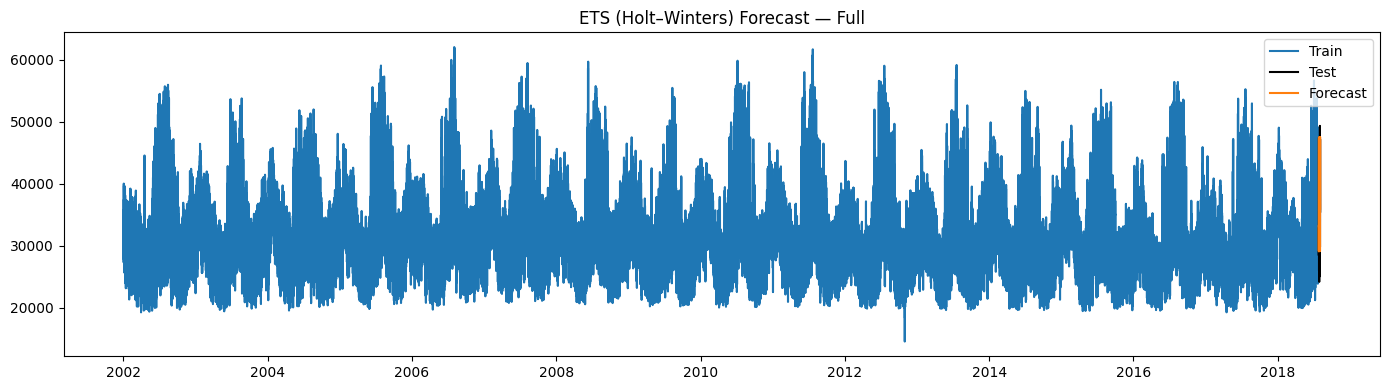

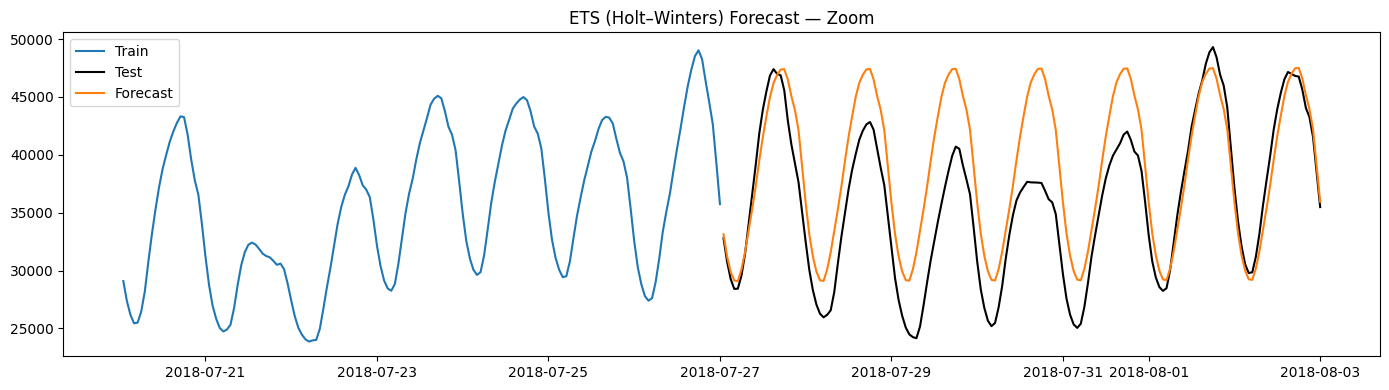

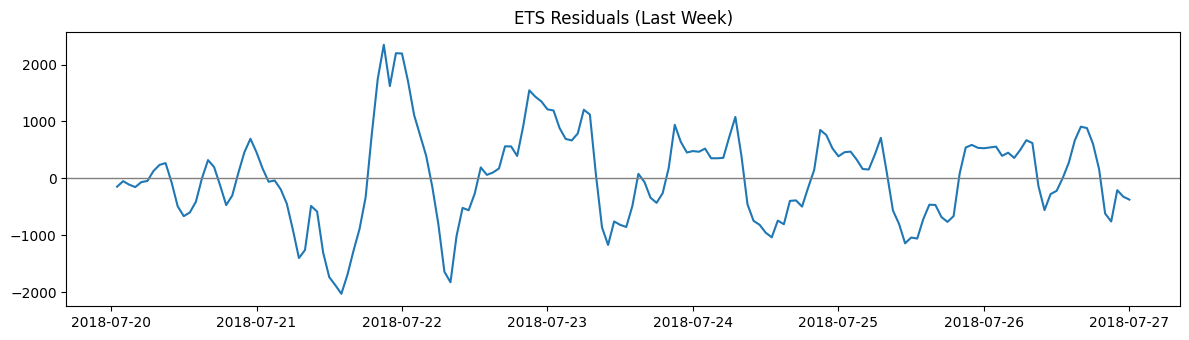

In [15]:
# ==== Classical Model: Exponential Smoothing (ETS) ====
from statsmodels.tsa.holtwinters import ExponentialSmoothing

# Fit ETS with additive trend and seasonality (daily = 24h cycle)
ets_model = ExponentialSmoothing(
    train['y'],
    trend='add',
    seasonal='add',
    seasonal_periods=SEASON_DAILY
).fit(optimized=True)

ets_forecast = ets_model.forecast(H)

mae_ets, rmse_ets = metrics(test['y'], ets_forecast)
print(f"ETS(add,add,add) → MAE={mae_ets:.3f}, RMSE={rmse_ets:.3f}")

plot_full_and_zoom(train, test, ets_forecast, title='ETS (Holt–Winters) Forecast')

# Residuals
resid = ets_model.resid
plt.figure(figsize=(12,3.5))
plt.plot(resid[-SEASON_WEEKLY:])
plt.axhline(0, color='gray', lw=1)
plt.title('ETS Residuals (Last Week)')
plt.tight_layout(); plt.show()

### STL Decomposition + ARIMA on Residuals

**STL (Seasonal-Trend decomposition using Loess)** separates the series into:
$$
y_t = T_t + S_t + R_t
$$
where:
- $T_t$ is a smooth trend,
- $S_t$ is the seasonal component,
- $R_t$ is the residual (stationary remainder).

You can model $R_t$ using an ARIMA or other model to capture remaining autocorrelation, then reconstruct forecasts:
$$
\hat{y}_{t+h} = \hat{T}_{t+h} + \hat{S}_{t+h} + \hat{R}_{t+h}
$$

This hybrid approach works well when seasonality amplitude or trend slope changes slowly over time — it decouples structure from noise.


STL + ARIMA → MAE=3162.269, RMSE=3708.441


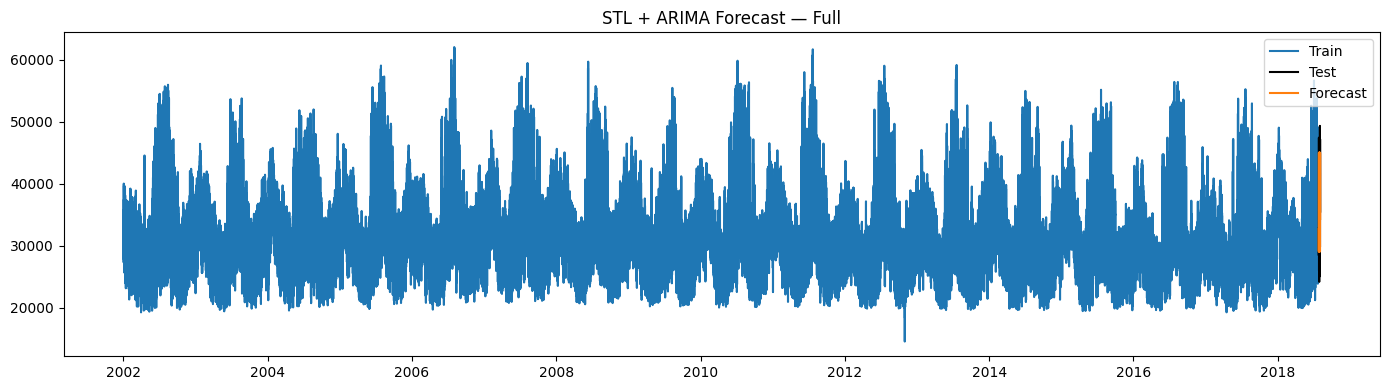

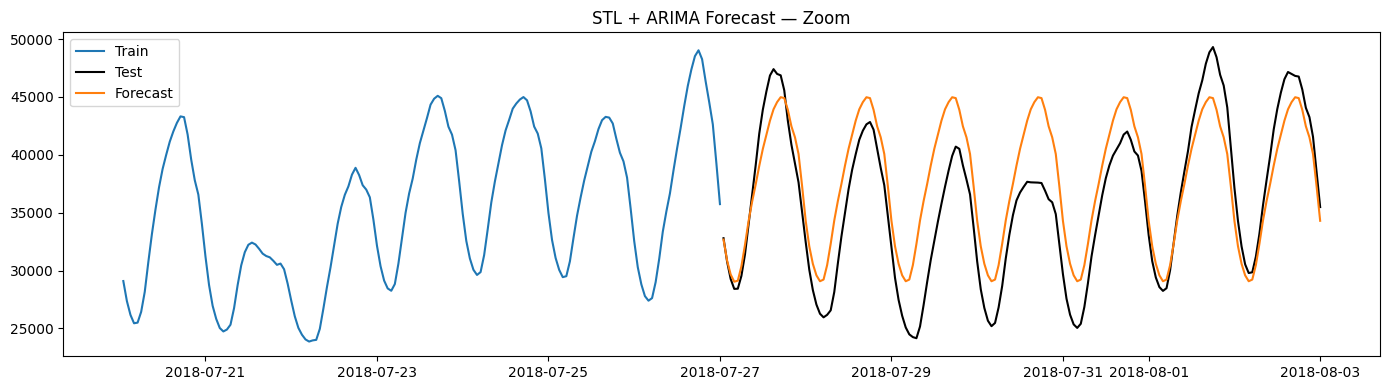

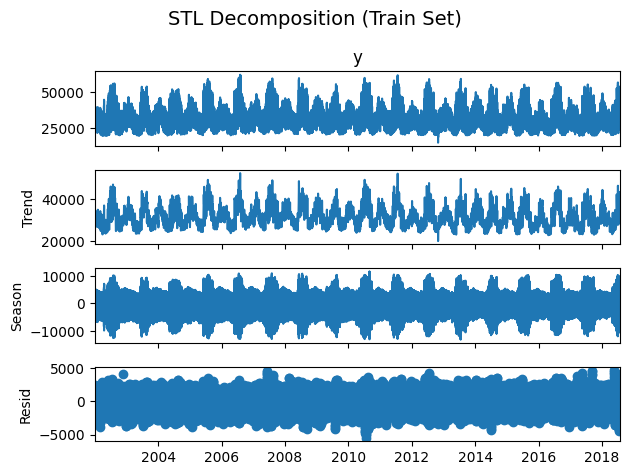

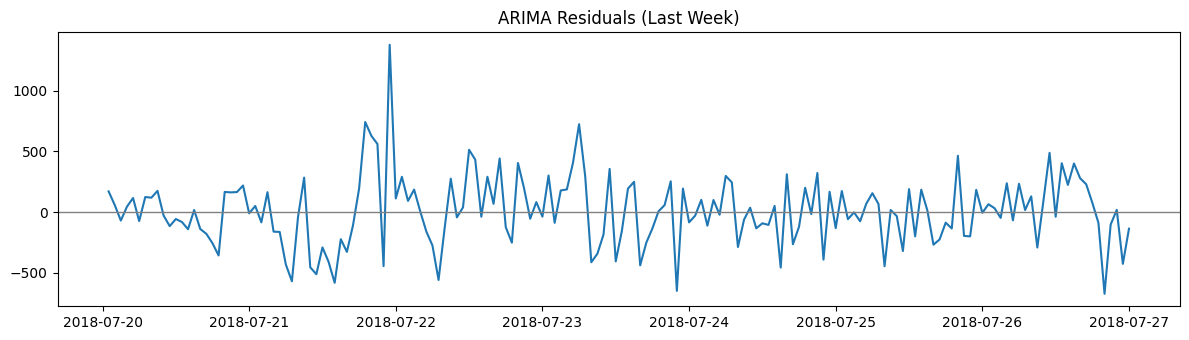

In [16]:
# ==== Classical Model: STL + ARIMA Hybrid ====
from statsmodels.tsa.seasonal import STL

# Decompose trend and seasonality (use 24h cycle)
stl = STL(train['y'], period=SEASON_DAILY)
res_stl = stl.fit()

trend = res_stl.trend
seasonal = res_stl.seasonal
resid = res_stl.resid

# Fit ARIMA to residuals
arima_resid = sm.tsa.arima.ARIMA(resid, order=(2,0,2)).fit()

# Forecast decomposition components
trend_future = trend.iloc[-SEASON_DAILY:].mean()  # assume near-flat local trend
seasonal_future = np.tile(seasonal.iloc[-SEASON_DAILY:], int(np.ceil(H/SEASON_DAILY)))[:H]
resid_forecast = arima_resid.forecast(H)

stl_forecast = trend_future + seasonal_future + resid_forecast

mae_stl, rmse_stl = metrics(test['y'], stl_forecast)
print(f"STL + ARIMA → MAE={mae_stl:.3f}, RMSE={rmse_stl:.3f}")

plot_full_and_zoom(train, test, stl_forecast, title='STL + ARIMA Forecast')

# Visualize decomposition
res_stl.plot()
plt.suptitle('STL Decomposition (Train Set)', fontsize=14)
plt.tight_layout(); plt.show()

# Residuals
resid = res.resid
plt.figure(figsize=(12,3.5))
plt.plot(resid[-SEASON_WEEKLY:])
plt.axhline(0, color='gray', lw=1)
plt.title('ARIMA Residuals (Last Week)')
plt.tight_layout(); plt.show()

## Machine Learning Approaches

Machine learning models do not assume a specific stochastic structure (like ARIMA’s autoregression or exponential smoothing).  
Instead, they **learn the mapping from engineered features** to future values directly through optimization.

**Core concept**

We create a supervised learning dataset from a time series by transforming it into input–output pairs:

$$
X_t = [y_{t-1}, y_{t-2}, \dots, y_{t-p}, \text{calendar\_features}_t, \text{exogenous}_t]
$$
$$
\hat{y}_t = f(X_t)
$$

Each model then learns $f$, the relationship between historical context and the target value.

**Common algorithms**
- **Tree ensembles:** Random Forests, Gradient Boosting (XGBoost, LightGBM, CatBoost).  
  Fast, interpretable feature importance, robust to nonlinearities.
- **Support Vector Regressors:** good for small, stationary datasets.
- **Linear and Ridge regressors:** equivalent to AR models when fed with lag features.
- **Hybrid or global models:** train across multiple series to share statistical strength.

**Strengths**
- Handle nonlinearity and interactions easily.
- Require fewer assumptions about stationarity.
- Scale to multivariate and exogenous regressors.

**Weaknesses**
- Require careful feature engineering to capture temporal structure.
- Don’t produce built-in uncertainty intervals (must be estimated via bootstrap or quantiles).
- Can overfit if windows are small or leakage occurs.

> We’ll build a tree-based global model (XGBoost) using lag and rolling features from the PJME series.


### XGBoost with Lag and Rolling Features

**Idea:** Transform the time series into a tabular regression dataset by adding lagged values, rolling window statistics, and calendar features.

For each timestamp $t$:
- `y_lag_k = y_{t-k}` (previous values)
- `rolling_mean_k = mean(y_{t-k \dots t-1})`
- `dow, hour, month` indicators

We train a regressor to predict $y_t$ given these features.  
For multi-step forecasts, we can use:
- **Recursive strategy:** predict one step, append it, and move forward.
- **Direct strategy:** train separate models per horizon (here we’ll do recursive for simplicity).


XGBoost Forecast → MAE=276.211, RMSE=346.504


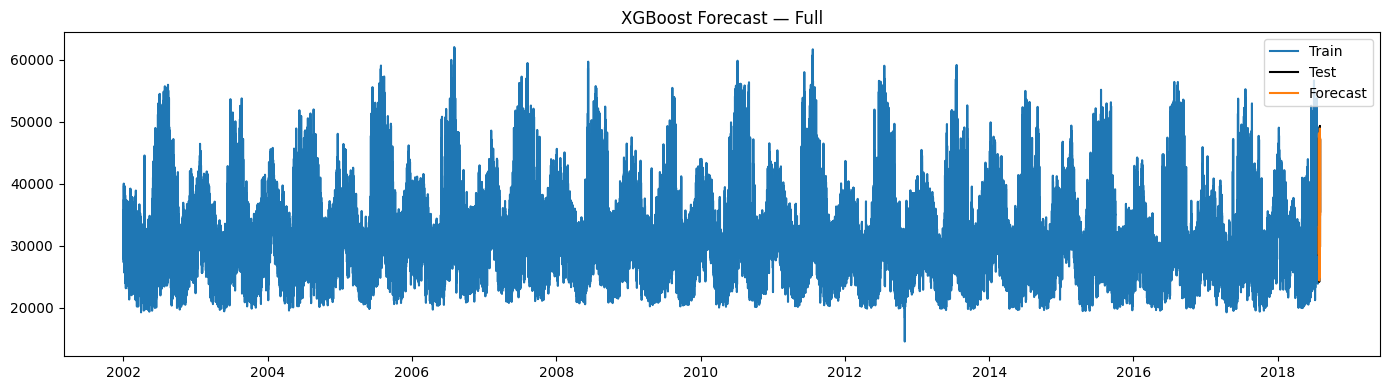

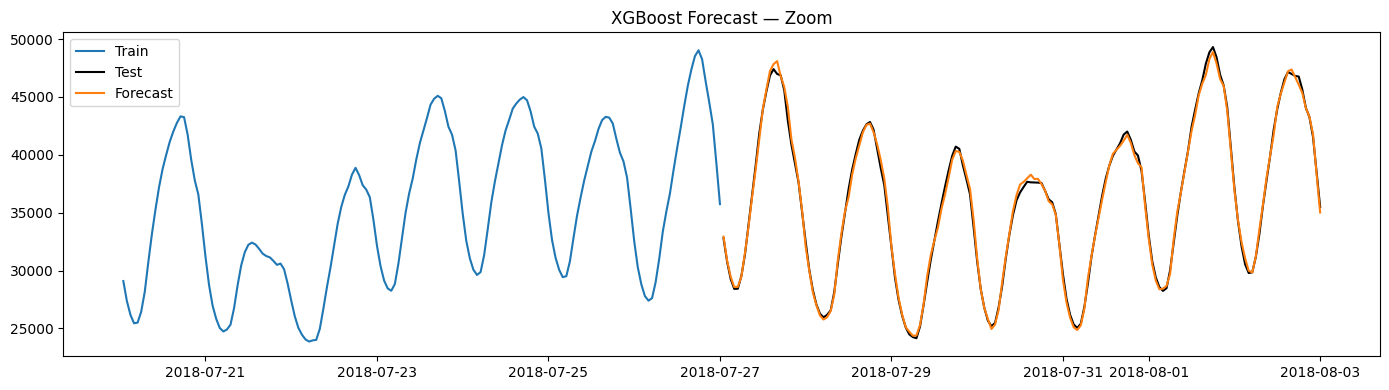

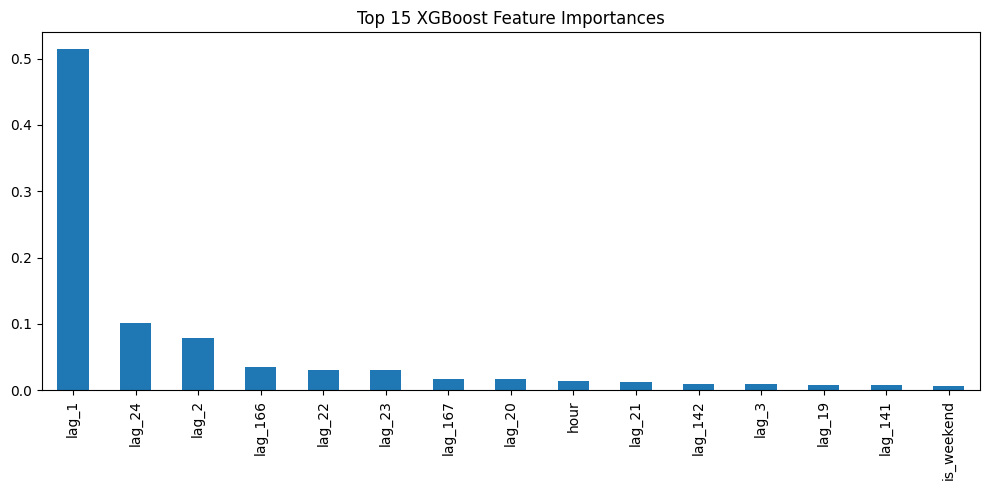

In [17]:
# ==== Machine Learning Model: XGBoost for Time Series Forecasting ====
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error

# --- Parameters ---
MAX_LAG = 168    # one week of lags
ROLLING_WINDOWS = [24, 168]

# --- Helper to create lagged features ---
def make_features(df, max_lag=MAX_LAG, rolling_windows=ROLLING_WINDOWS):
    df_feat = df.copy()
    for lag in range(1, max_lag + 1):
        df_feat[f"lag_{lag}"] = df_feat['y'].shift(lag)
    for w in rolling_windows:
        df_feat[f"roll_mean_{w}"] = df_feat['y'].shift(1).rolling(w).mean()
        df_feat[f"roll_std_{w}"] = df_feat['y'].shift(1).rolling(w).std()
    # calendar features
    df_feat['hour'] = df_feat.index.hour
    df_feat['dayofweek'] = df_feat.index.dayofweek
    df_feat['month'] = df_feat.index.month
    df_feat['is_weekend'] = (df_feat['dayofweek'] >= 5).astype(int)
    return df_feat.dropna()

# --- Build features ---
features = make_features(df)
X = features.drop(columns=['y'])
y = features['y']

# Align train/test periods
X_train, X_test = X.loc[train.index.intersection(X.index)], X.loc[test.index.intersection(X.index)]
y_train, y_test = y.loc[train.index.intersection(y.index)], y.loc[test.index.intersection(y.index)]

# --- Train XGBoost regressor ---
model_xgb = XGBRegressor(
    n_estimators=300,
    max_depth=8,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    tree_method='hist'
)

model_xgb.fit(X_train, y_train, verbose=False)

# --- Predict ---
y_pred = model_xgb.predict(X_test)

# --- Evaluate ---
mae, rmse = metrics(y_test, y_pred)
print(f"XGBoost Forecast → MAE={mae:.3f}, RMSE={rmse:.3f}")

# --- Plot forecasts ---
plot_full_and_zoom(train, test, y_pred, title='XGBoost Forecast')

# --- Feature importance ---
importances = pd.Series(model_xgb.feature_importances_, index=X_train.columns).sort_values(ascending=False)
plt.figure(figsize=(10,5))
importances.head(15).plot(kind='bar')
plt.title("Top 15 XGBoost Feature Importances")
plt.tight_layout(); plt.show()

### Random Forests for Time Series Forecasting

A **Random Forest (RF)** is an ensemble of decision trees trained on random subsets of the data and features.  
Each tree provides its own prediction; the forest’s output is the average of all trees.

**Key ideas**
- No assumptions about linearity or stationarity.
- Naturally captures nonlinear interactions between lagged features.
- Resistant to overfitting because of bootstrapping and feature subsampling.
- Works best when many informative lag or calendar features are available.

**Limitations**
- Cannot extrapolate trends beyond observed values.
- No built-in understanding of temporal order; relies entirely on engineered lags.

**Use cases**
- Strong baseline for short-term forecasts.
- Often paired with feature sets identical to those used for boosted trees (XGBoost, LightGBM).


Random Forest Forecast → MAE=237.149, RMSE=310.073


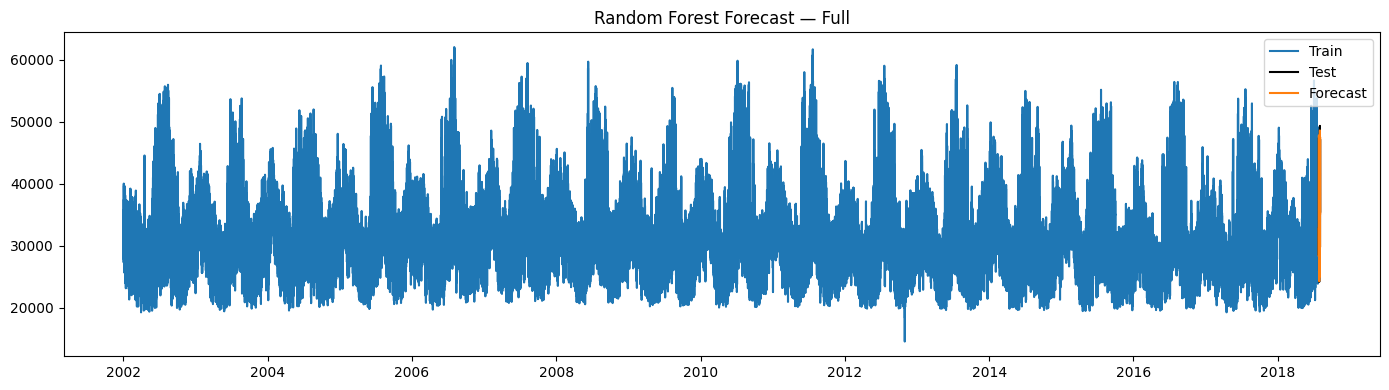

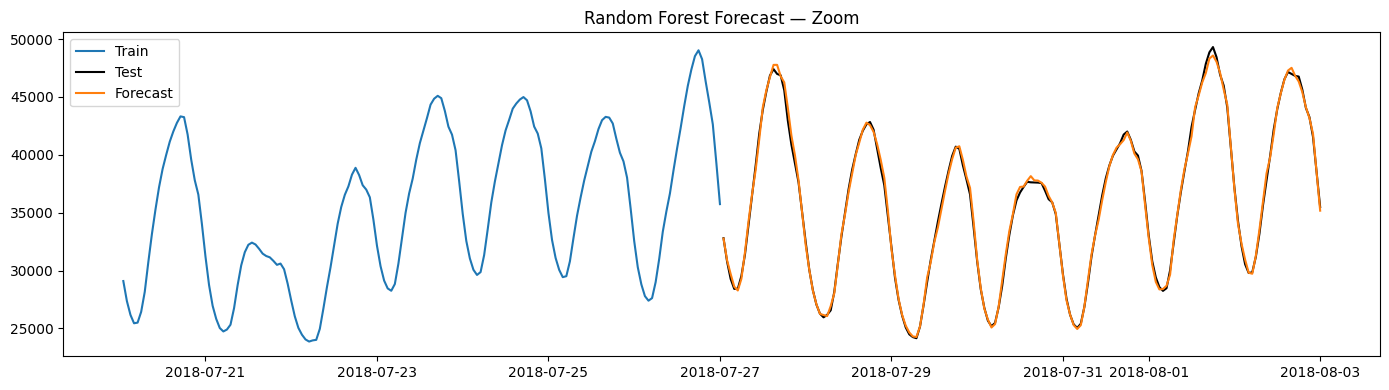

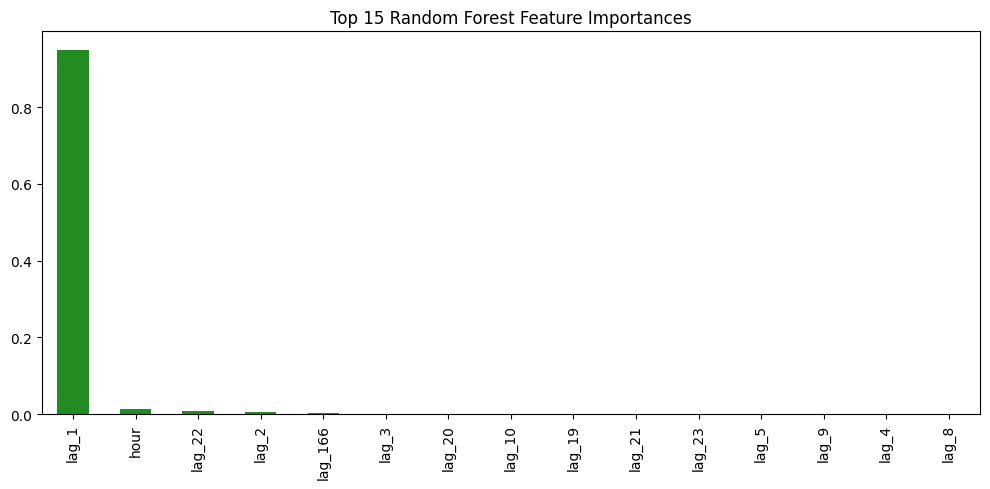

In [24]:
# ==== Machine Learning Model: Random Forest Regressor ====
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt
import pandas as pd

# Reuse the feature matrix 'features' built earlier for XGBoost
X = features.drop(columns=['y'])
y = features['y']

# Align with train/test periods
X_train = X.loc[train.index.intersection(X.index)]
X_test = X.loc[test.index.intersection(X.index)]
y_train = y.loc[train.index.intersection(y.index)]
y_test = y.loc[test.index.intersection(y.index)]

# --- Train Random Forest ---
rf_model = RandomForestRegressor(
    n_estimators=300,
    max_depth=20,
    n_jobs=-1,
    random_state=42,
    min_samples_leaf=3
)
rf_model.fit(X_train, y_train)

# --- Predict ---
y_pred_rf = rf_model.predict(X_test)

# --- Evaluate ---
mae_rf, rmse_rf = metrics(y_test, y_pred_rf)
print(f"Random Forest Forecast → MAE={mae_rf:.3f}, RMSE={rmse_rf:.3f}")

# --- Plot results ---
plot_full_and_zoom(train, test, y_pred_rf, title='Random Forest Forecast')

# --- Feature importance ---
fi_rf = pd.Series(rf_model.feature_importances_, index=X_train.columns).sort_values(ascending=False)
plt.figure(figsize=(10,5))
fi_rf.head(15).plot(kind='bar', color='forestgreen')
plt.title("Top 15 Random Forest Feature Importances")
plt.tight_layout(); plt.show()


## Deep Learning Approaches for Time Series

Deep learning models learn **representations** of temporal structure instead of manual feature engineering.  
They operate directly on sequential inputs — windows of recent observations — and can model nonlinear, long-range dependencies.

**Philosophy**
- Feed raw or minimally processed sequences into a network.
- Let the model discover latent temporal features through layers of neurons.
- Predict the next value (or multiple future steps) directly.

**Common architectures**
- **RNN / LSTM / GRU:** sequential networks that propagate state over time.
- **Temporal Convolutional Networks (TCN):** causal 1-D convolutions with large receptive fields.
- **Transformers:** attention-based sequence models that scale to long horizons.

**Strengths**
- Capture complex, nonlinear relationships.
- Work well with multivariate inputs.
- Naturally extend to probabilistic or multi-horizon forecasting.

**Limitations**
- Require more data and tuning.
- Training is slower than classical or ML models.
- Less interpretable; rely on visualization and attribution techniques.


### Long Short-Term Memory (LSTM)

An **LSTM** network is a special type of Recurrent Neural Network (RNN) designed to remember information over long sequences.  
It uses gating mechanisms to control how information flows through time:

- **Input gate:** decides how much of the new input to store.
- **Forget gate:** decides what part of the past state to discard.
- **Output gate:** decides what to pass to the next layer or output.

Equations (simplified):

$$
f_t = \sigma(W_f [h_{t-1}, x_t] + b_f) \\
i_t = \sigma(W_i [h_{t-1}, x_t] + b_i) \\
o_t = \sigma(W_o [h_{t-1}, x_t] + b_o) \\
c_t = f_t * c_{t-1} + i_t * \tanh(W_c [h_{t-1}, x_t] + b_c) \\
h_t = o_t * \tanh(c_t)
$$

This structure allows the network to “remember” seasonal and trend patterns across many time steps, making it ideal for time-series forecasting.


Train sequences: (145056, 168), Test sequences: (168, 168)
Epoch 1/10
2040/2040 ━━━━━━━━━━━━━━━━━━━━ 59s 29ms/step - loss: 0.1001 - val_loss: 0.0077
Epoch 2/10
2040/2040 ━━━━━━━━━━━━━━━━━━━━ 60s 30ms/step - loss: 0.0126 - val_loss: 0.0054
Epoch 3/10
2040/2040 ━━━━━━━━━━━━━━━━━━━━ 58s 28ms/step - loss: 0.0100 - val_loss: 0.0044
Epoch 4/10
2040/2040 ━━━━━━━━━━━━━━━━━━━━ 58s 28ms/step - loss: 0.0087 - val_loss: 0.0096
Epoch 5/10
2040/2040 ━━━━━━━━━━━━━━━━━━━━ 57s 28ms/step - loss: 0.0075 - val_loss: 0.0214
Epoch 6/10
2040/2040 ━━━━━━━━━━━━━━━━━━━━ 56s 27ms/step - loss: 0.0066 - val_loss: 0.0243
Epoch 7/10
2040/2040 ━━━━━━━━━━━━━━━━━━━━ 58s 28ms/step - loss: 0.0059 - val_loss: 0.0436
Epoch 8/10
2040/2040 ━━━━━━━━━━━━━━━━━━━━ 58s 28ms/step - loss: 0.0053 - val_loss: 0.0498
Epoch 9/10
2040/2040 ━━━━━━━━━━━━━━━━━━━━ 58s 28ms/step - loss: 0.0048 - val_loss: 0.0760
Epoch 10/10
2040/2040 ━━━━━━━━━━━━━━━━━━━━ 58s 29ms/step - loss: 0.0044 - val_loss: 0.0743
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
LS

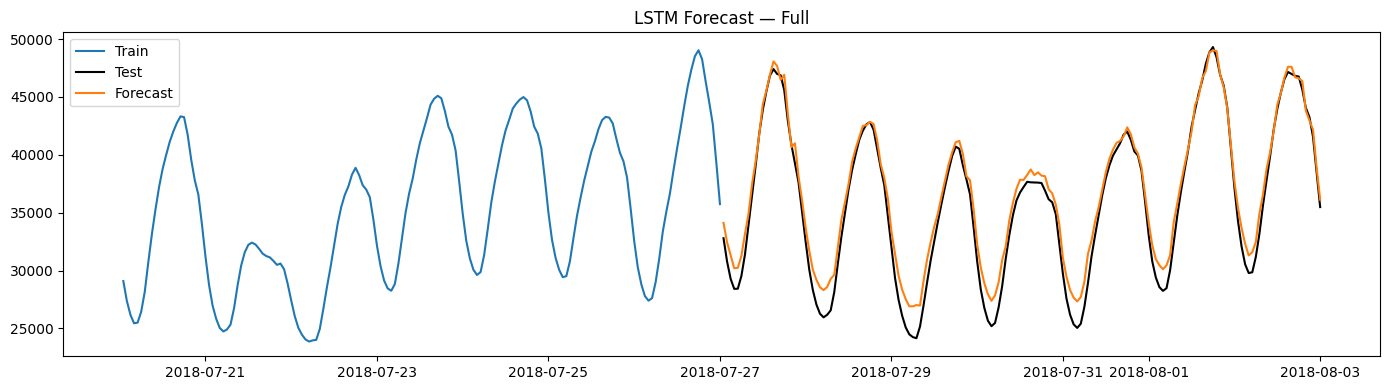

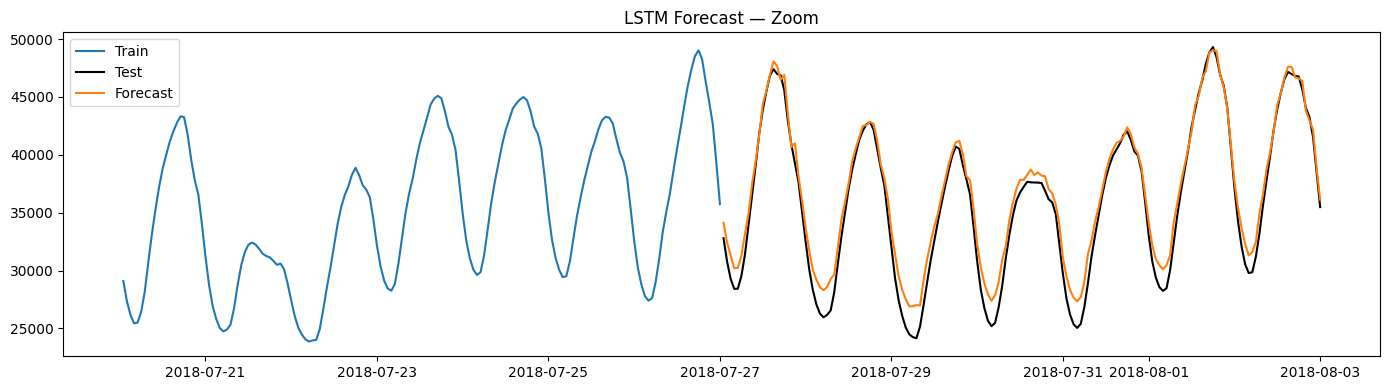

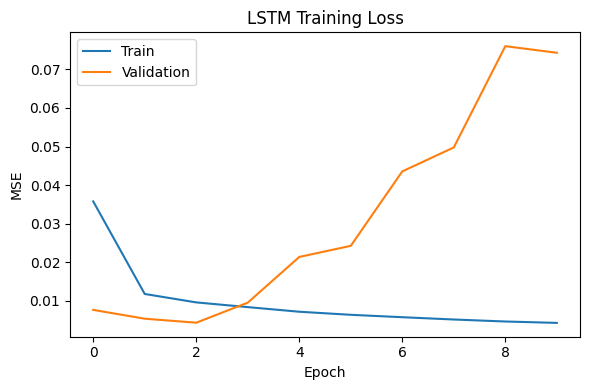

In [20]:
# ==== Deep Learning Model: LSTM for Time Series Forecasting ====
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import mean_absolute_error, mean_squared_error

# --- Prepare supervised learning sequences ---
def create_sequences(series, window=168):
    X, y = [], []
    for i in range(window, len(series)):
        X.append(series[i-window:i])
        y.append(series[i])
    return np.array(X), np.array(y)

WINDOW = 168  # one week of hourly context

scaler = StandardScaler()
y_scaled = scaler.fit_transform(df[['y']])

X_all, y_all = create_sequences(y_scaled.flatten(), window=WINDOW)

# Split into train/test respecting chronological order
split = len(train) - WINDOW
X_train, y_train = X_all[:split], y_all[:split]
X_test, y_test = X_all[split:], y_all[split:]

print(f"Train sequences: {X_train.shape}, Test sequences: {X_test.shape}")

# --- Build LSTM model ---
model = Sequential([
    LSTM(64, input_shape=(WINDOW, 1), return_sequences=False),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dense(1)
])

model.compile(loss='mse', optimizer=Adam(learning_rate=0.001))

# --- Train ---
history = model.fit(
    X_train, y_train,
    validation_split=0.1,
    epochs=10,
    batch_size=64,
    verbose=1
)

# --- Predict ---
y_pred_scaled = model.predict(X_test)
y_pred = scaler.inverse_transform(y_pred_scaled.reshape(-1, 1)).flatten()
y_true = scaler.inverse_transform(y_test.reshape(-1, 1)).flatten()

# --- Evaluate ---
mae_dl, rmse_dl = metrics(y_true, y_pred)
print(f"LSTM Forecast → MAE={mae_dl:.3f}, RMSE={rmse_dl:.3f}")

# --- Plot ---
plot_full_and_zoom(train.iloc[-len(y_true):], test, y_pred, title='LSTM Forecast')

# --- Training history ---
plt.figure(figsize=(6,4))
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Validation')
plt.title('LSTM Training Loss')
plt.xlabel('Epoch'); plt.ylabel('MSE')
plt.legend(); plt.tight_layout(); plt.show()


### Recurrent Neural Networks (RNN)

A **Recurrent Neural Network** processes sequential data by maintaining a hidden state that carries information forward through time.

For each time step \( t \):
$$
h_t = \tanh(W_h h_{t-1} + W_x x_t + b_h)
$$
$$
\hat{y}_t = W_y h_t + b_y
$$

Here:
- \( h_t \) is the hidden state at time \( t \),
- \( x_t \) is the input (e.g., the value at that hour),
- \( W_h, W_x, W_y \) are learnable weight matrices.

The RNN “remembers” previous states implicitly through \( h_{t-1} \).  
However, due to vanishing and exploding gradients, vanilla RNNs struggle with long-term dependencies — hence the development of **LSTM** and **GRU**.

Despite that, RNNs still work well for short-memory forecasting tasks and are computationally lighter than gated versions.


Epoch 1/10
2040/2040 ━━━━━━━━━━━━━━━━━━━━ 19s 9ms/step - loss: 0.0347 - val_loss: 0.0032
Epoch 2/10
2040/2040 ━━━━━━━━━━━━━━━━━━━━ 18s 9ms/step - loss: 0.0083 - val_loss: 0.0031
Epoch 3/10
2040/2040 ━━━━━━━━━━━━━━━━━━━━ 18s 9ms/step - loss: 0.0079 - val_loss: 0.0034
Epoch 4/10
2040/2040 ━━━━━━━━━━━━━━━━━━━━ 18s 9ms/step - loss: 0.0074 - val_loss: 0.0034
Epoch 5/10
2040/2040 ━━━━━━━━━━━━━━━━━━━━ 18s 9ms/step - loss: 0.0072 - val_loss: 0.0029
Epoch 6/10
2040/2040 ━━━━━━━━━━━━━━━━━━━━ 18s 9ms/step - loss: 0.0067 - val_loss: 0.0032
Epoch 7/10
2040/2040 ━━━━━━━━━━━━━━━━━━━━ 18s 9ms/step - loss: 0.0068 - val_loss: 0.0030
Epoch 8/10
2040/2040 ━━━━━━━━━━━━━━━━━━━━ 18s 9ms/step - loss: 0.0065 - val_loss: 0.0026
Epoch 9/10
2040/2040 ━━━━━━━━━━━━━━━━━━━━ 18s 9ms/step - loss: 0.0064 - val_loss: 0.0029
Epoch 10/10
2040/2040 ━━━━━━━━━━━━━━━━━━━━ 19s 9ms/step - loss: 0.0061 - val_loss: 0.0032
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
RNN Forecast → MAE=326.511, RMSE=422.994


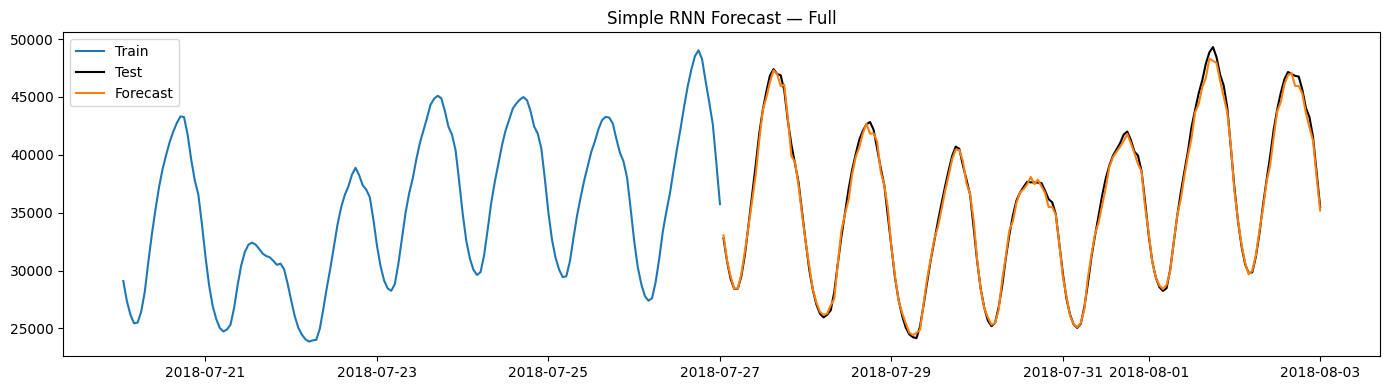

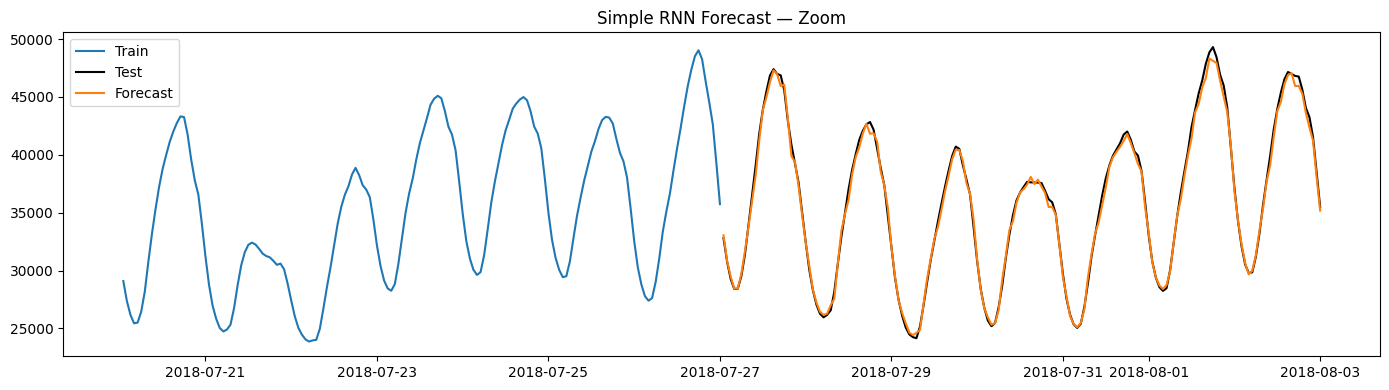

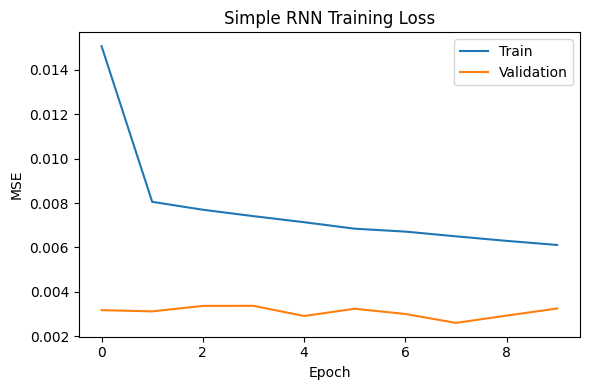

In [21]:
# ==== Deep Learning Model: Simple RNN for Time Series Forecasting ====
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Reuse sequence creation and scaling
def create_sequences(series, window=168):
    X, y = [], []
    for i in range(window, len(series)):
        X.append(series[i-window:i])
        y.append(series[i])
    return np.array(X), np.array(y)

WINDOW = 168  # one week context

scaler = StandardScaler()
y_scaled = scaler.fit_transform(df[['y']])
X_all, y_all = create_sequences(y_scaled.flatten(), window=WINDOW)

split = len(train) - WINDOW
X_train, y_train = X_all[:split], y_all[:split]
X_test, y_test = X_all[split:], y_all[split:]

# Build model
model_rnn = Sequential([
    SimpleRNN(64, input_shape=(WINDOW, 1), return_sequences=False),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dense(1)
])

model_rnn.compile(loss='mse', optimizer=Adam(learning_rate=0.001))

# Train
history_rnn = model_rnn.fit(
    X_train, y_train,
    validation_split=0.1,
    epochs=10,
    batch_size=64,
    verbose=1
)

# Predict
y_pred_scaled = model_rnn.predict(X_test)
y_pred = scaler.inverse_transform(y_pred_scaled.reshape(-1, 1)).flatten()
y_true = scaler.inverse_transform(y_test.reshape(-1, 1)).flatten()

# Evaluate
mae_rnn, rmse_rnn = metrics(y_true, y_pred)
print(f"RNN Forecast → MAE={mae_rnn:.3f}, RMSE={rmse_rnn:.3f}")

# Plot results
plot_full_and_zoom(train.iloc[-len(y_true):], test, y_pred, title='Simple RNN Forecast')

# Plot training history
plt.figure(figsize=(6,4))
plt.plot(history_rnn.history['loss'], label='Train')
plt.plot(history_rnn.history['val_loss'], label='Validation')
plt.title('Simple RNN Training Loss')
plt.xlabel('Epoch'); plt.ylabel('MSE')
plt.legend(); plt.tight_layout(); plt.show()


### Temporal Convolutional Networks (TCN)

A **Temporal Convolutional Network** models sequences using **causal 1-D convolutions** — filters that slide over time but never “peek” into the future.  
Unlike RNNs, which process one step at a time, TCNs can process entire windows in parallel.

**Core principles**
- **Causal convolution:** ensures predictions at time \( t \) depend only on data up to \( t \).
- **Dilation:** exponentially increases the receptive field so the model can see far into the past without huge depth.
- **Residual blocks:** stabilize training by adding skip connections.

The effective receptive field of a dilated convolution layer with kernel size \( k \) and dilation \( d \) is:
$$
R = (k - 1) \times d + 1
$$

By stacking layers with increasing dilation (1, 2, 4, 8, ...), a TCN can learn dependencies hundreds of steps back efficiently.

**Why use it**
- Parallelizable (faster than RNN/LSTM).
- Naturally handles variable-length sequences.
- Works well for local periodicity (daily/weekly cycles).


Epoch 1/10
2040/2040 ━━━━━━━━━━━━━━━━━━━━ 26s 13ms/step - loss: 0.0695 - val_loss: 0.0096
Epoch 2/10
2040/2040 ━━━━━━━━━━━━━━━━━━━━ 24s 12ms/step - loss: 0.0100 - val_loss: 0.0097
Epoch 3/10
2040/2040 ━━━━━━━━━━━━━━━━━━━━ 23s 11ms/step - loss: 0.0070 - val_loss: 0.0052
Epoch 4/10
2040/2040 ━━━━━━━━━━━━━━━━━━━━ 23s 11ms/step - loss: 0.0063 - val_loss: 0.0060
Epoch 5/10
2040/2040 ━━━━━━━━━━━━━━━━━━━━ 23s 11ms/step - loss: 0.0059 - val_loss: 0.0061
Epoch 6/10
2040/2040 ━━━━━━━━━━━━━━━━━━━━ 24s 12ms/step - loss: 0.0052 - val_loss: 0.0038
Epoch 7/10
2040/2040 ━━━━━━━━━━━━━━━━━━━━ 25s 12ms/step - loss: 0.0049 - val_loss: 0.0029
Epoch 8/10
2040/2040 ━━━━━━━━━━━━━━━━━━━━ 24s 12ms/step - loss: 0.0048 - val_loss: 0.0043
Epoch 9/10
2040/2040 ━━━━━━━━━━━━━━━━━━━━ 24s 12ms/step - loss: 0.0046 - val_loss: 0.0053
Epoch 10/10
2040/2040 ━━━━━━━━━━━━━━━━━━━━ 24s 12ms/step - loss: 0.0043 - val_loss: 0.0028
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
TCN Forecast → MAE=331.358, RMSE=433.530


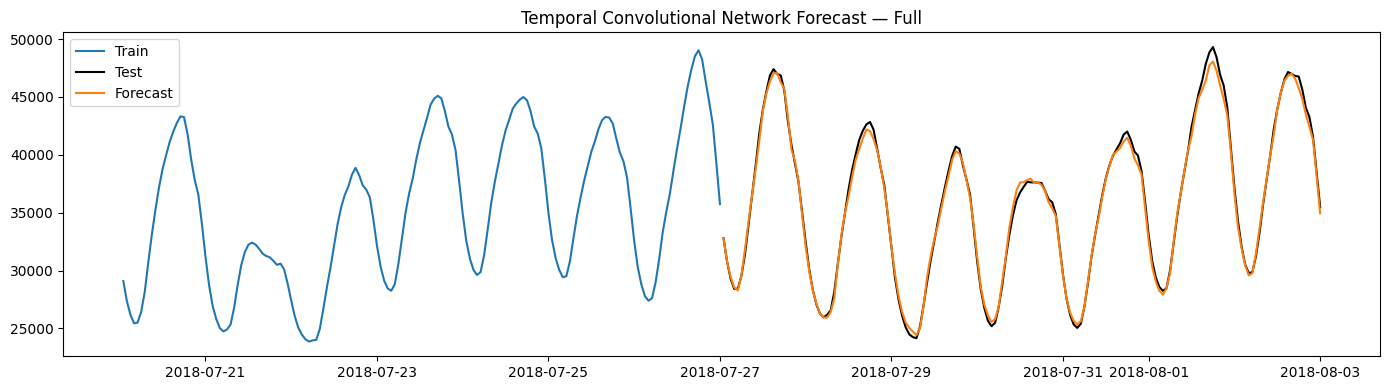

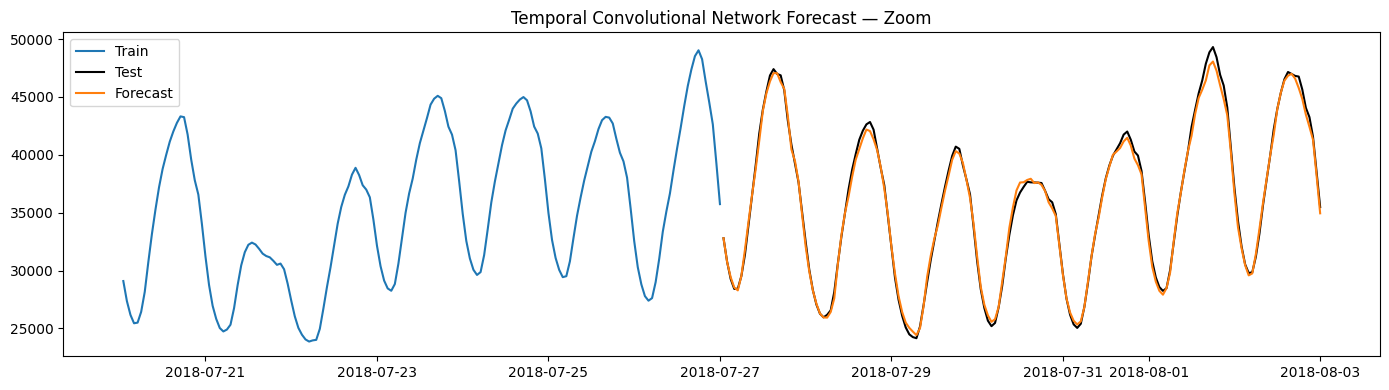

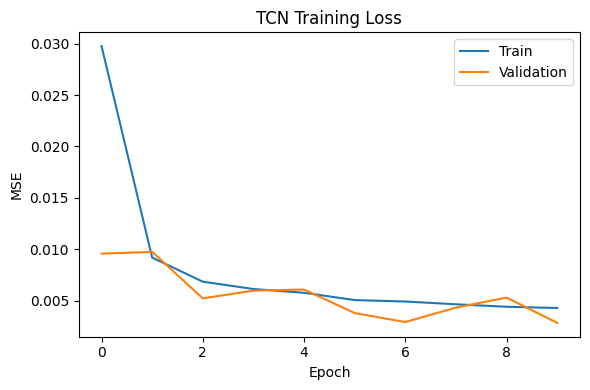

In [22]:
# ==== Deep Learning Model: Temporal Convolutional Network (TCN) ====
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Prepare data (same window creation as before)
def create_sequences(series, window=168):
    X, y = [], []
    for i in range(window, len(series)):
        X.append(series[i-window:i])
        y.append(series[i])
    return np.array(X), np.array(y)

WINDOW = 168

scaler = StandardScaler()
y_scaled = scaler.fit_transform(df[['y']])
X_all, y_all = create_sequences(y_scaled.flatten(), window=WINDOW)

split = len(train) - WINDOW
X_train, y_train = X_all[:split], y_all[:split]
X_test, y_test = X_all[split:], y_all[split:]

# Add channel dimension for Conv1D
X_train = np.expand_dims(X_train, axis=2)
X_test = np.expand_dims(X_test, axis=2)

# Build simple TCN-like model
model_tcn = Sequential([
    Conv1D(filters=64, kernel_size=3, activation='relu', padding='causal', dilation_rate=1, input_shape=(WINDOW, 1)),
    Dropout(0.2),
    Conv1D(filters=64, kernel_size=3, activation='relu', padding='causal', dilation_rate=2),
    Dropout(0.2),
    Conv1D(filters=64, kernel_size=3, activation='relu', padding='causal', dilation_rate=4),
    Flatten(),
    Dense(64, activation='relu'),
    Dense(1)
])

model_tcn.compile(loss='mse', optimizer=Adam(learning_rate=0.001))

# Train
history_tcn = model_tcn.fit(
    X_train, y_train,
    validation_split=0.1,
    epochs=10,
    batch_size=64,
    verbose=1
)

# Predict
y_pred_scaled = model_tcn.predict(X_test)
y_pred = scaler.inverse_transform(y_pred_scaled.reshape(-1, 1)).flatten()
y_true = scaler.inverse_transform(y_test.reshape(-1, 1)).flatten()

# Evaluate
mae_tcn, rmse_tcn = metrics(y_true, y_pred)
print(f"TCN Forecast → MAE={mae_tcn:.3f}, RMSE={rmse_tcn:.3f}")

# Plot forecasts
plot_full_and_zoom(train.iloc[-len(y_true):], test, y_pred, title='Temporal Convolutional Network Forecast')

# Plot training history
plt.figure(figsize=(6,4))
plt.plot(history_tcn.history['loss'], label='Train')
plt.plot(history_tcn.history['val_loss'], label='Validation')
plt.title('TCN Training Loss')
plt.xlabel('Epoch'); plt.ylabel('MSE')
plt.legend(); plt.tight_layout(); plt.show()


### Transformer-Based Forecasting

Transformers replace recurrence with **self-attention** — a mechanism that allows the model to learn which past points are most relevant to the current prediction.

For an input sequence \( X = [x_1, x_2, ..., x_T] \):
1. Each time step is projected into a latent space (embedding).
2. The model computes **attention weights** between all pairs of time steps:
   $$
   \text{Attention}(Q, K, V) = \text{softmax}\left(\frac{QK^T}{\sqrt{d_k}}\right)V
   $$
   where \( Q, K, V \) are the query, key, and value matrices derived from \( X \).
3. The outputs of all attention heads are combined and passed through feedforward layers.

**Advantages**
- Captures long-term dependencies efficiently.
- Parallelizable across time steps.
- Easily extended to multivariate or multi-horizon forecasting.

**Challenges**
- Requires more data and compute than RNN/TCN models.
- Sensitive to scaling and sequence length.


Epoch 1/10
2040/2040 ━━━━━━━━━━━━━━━━━━━━ 138s 67ms/step - loss: 0.7028 - val_loss: 0.6149
Epoch 2/10
2040/2040 ━━━━━━━━━━━━━━━━━━━━ 114s 56ms/step - loss: 0.6931 - val_loss: 0.6157
Epoch 3/10
2040/2040 ━━━━━━━━━━━━━━━━━━━━ 112s 55ms/step - loss: 0.6868 - val_loss: 0.6126
Epoch 4/10
2040/2040 ━━━━━━━━━━━━━━━━━━━━ 116s 57ms/step - loss: 0.6900 - val_loss: 0.6125
Epoch 5/10
2040/2040 ━━━━━━━━━━━━━━━━━━━━ 113s 55ms/step - loss: 0.6938 - val_loss: 0.6151
Epoch 6/10
2040/2040 ━━━━━━━━━━━━━━━━━━━━ 126s 62ms/step - loss: 0.6849 - val_loss: 0.6144
Epoch 7/10
2040/2040 ━━━━━━━━━━━━━━━━━━━━ 119s 59ms/step - loss: 0.6914 - val_loss: 0.6160
Epoch 8/10
2040/2040 ━━━━━━━━━━━━━━━━━━━━ 116s 57ms/step - loss: 0.6946 - val_loss: 0.6118
Epoch 9/10
2040/2040 ━━━━━━━━━━━━━━━━━━━━ 116s 57ms/step - loss: 0.6895 - val_loss: 0.6136
Epoch 10/10
2040/2040 ━━━━━━━━━━━━━━━━━━━━ 151s 74ms/step - loss: 0.6895 - val_loss: 0.6157
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Transformer Forecast → MAE=5759.475, RMSE=6823.764


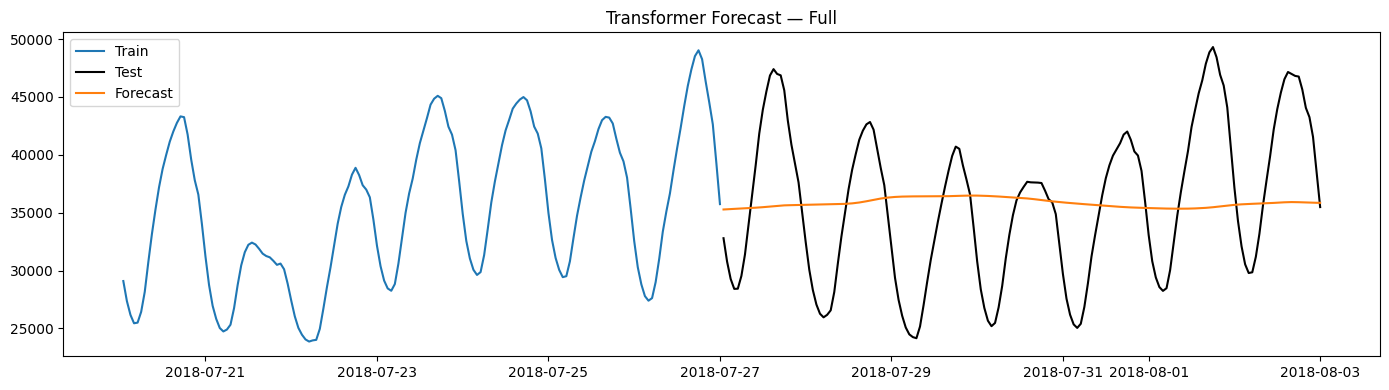

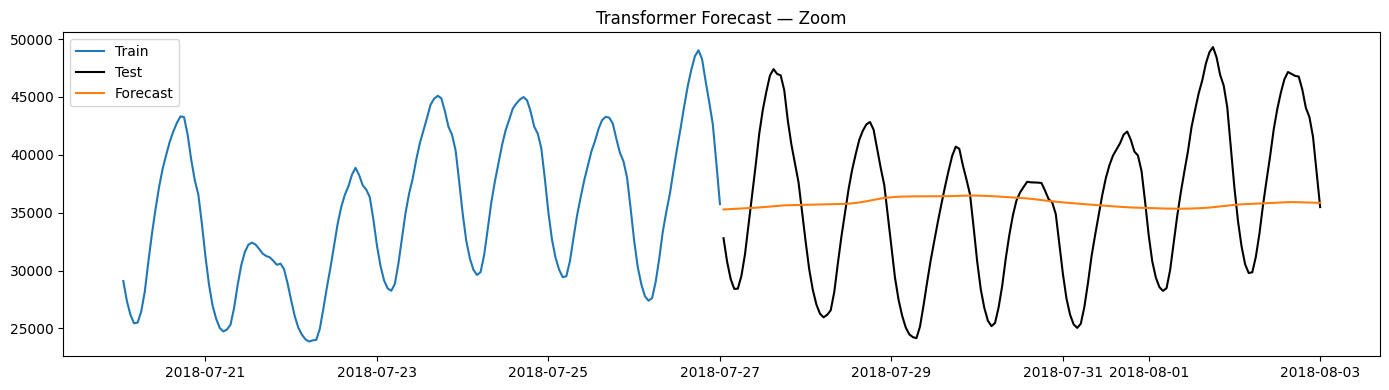

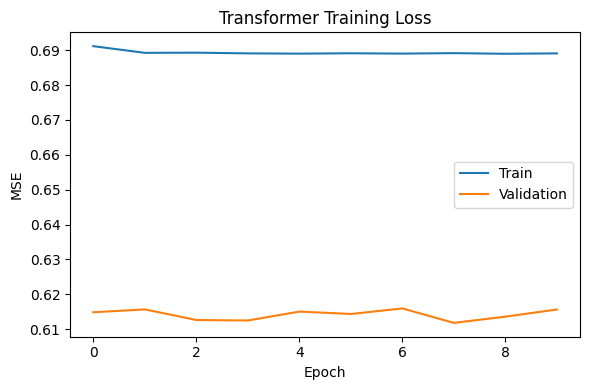

In [23]:
# ==== Deep Learning Model: Transformer Encoder for Time Series ====
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Data prep (same as previous models)
def create_sequences(series, window=168):
    X, y = [], []
    for i in range(window, len(series)):
        X.append(series[i-window:i])
        y.append(series[i])
    return np.array(X), np.array(y)

WINDOW = 168
scaler = StandardScaler()
y_scaled = scaler.fit_transform(df[['y']])
X_all, y_all = create_sequences(y_scaled.flatten(), window=WINDOW)

split = len(train) - WINDOW
X_train, y_train = X_all[:split], y_all[:split]
X_test, y_test = X_all[split:], y_all[split:]

# --- Transformer encoder block ---
def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
    # Multi-head self-attention
    x = layers.MultiHeadAttention(num_heads=num_heads, key_dim=head_size, dropout=dropout)(inputs, inputs)
    x = layers.Dropout(dropout)(x)
    x = layers.LayerNormalization(epsilon=1e-6)(x)
    res = x + inputs

    # Feedforward block
    x = layers.Conv1D(filters=ff_dim, kernel_size=1, activation="relu")(res)
    x = layers.Dropout(dropout)(x)
    x = layers.Conv1D(filters=inputs.shape[-1], kernel_size=1)(x)
    x = layers.LayerNormalization(epsilon=1e-6)(x)
    return x + res

# --- Build model ---
inputs = layers.Input(shape=(WINDOW, 1))
x = transformer_encoder(inputs, head_size=32, num_heads=2, ff_dim=64, dropout=0.1)
x = transformer_encoder(x, head_size=32, num_heads=2, ff_dim=64, dropout=0.1)
x = layers.GlobalAveragePooling1D()(x)
x = layers.Dense(64, activation="relu")(x)
outputs = layers.Dense(1)(x)
model_tf = models.Model(inputs, outputs)

model_tf.compile(loss="mse", optimizer=tf.keras.optimizers.Adam(learning_rate=0.001))

# --- Train ---
history_tf = model_tf.fit(
    X_train, y_train,
    validation_split=0.1,
    epochs=10,
    batch_size=64,
    verbose=1
)

# --- Predict ---
y_pred_scaled = model_tf.predict(X_test)
y_pred = scaler.inverse_transform(y_pred_scaled.reshape(-1, 1)).flatten()
y_true = scaler.inverse_transform(y_test.reshape(-1, 1)).flatten()

# --- Evaluate ---
mae_tf, rmse_tf = metrics(y_true, y_pred)
print(f"Transformer Forecast → MAE={mae_tf:.3f}, RMSE={rmse_tf:.3f}")

# --- Plot results ---
plot_full_and_zoom(train.iloc[-len(y_true):], test, y_pred, title='Transformer Forecast')

# --- Plot training history ---
plt.figure(figsize=(6,4))
plt.plot(history_tf.history['loss'], label='Train')
plt.plot(history_tf.history['val_loss'], label='Validation')
plt.title('Transformer Training Loss')
plt.xlabel('Epoch'); plt.ylabel('MSE')
plt.legend(); plt.tight_layout(); plt.show()
